# Sine overlay creating beat

- explicit version
- random version
- using own functions
- using mixer

In [1]:
# the waveshape module is in the parent directory
import sys
sys.path.insert(0, '..')

## Create an audio signal


In [2]:
import wavestacker
import numpy as np

freq = 220
duration = 1
t = np.linspace(0, duration, int(duration*44100))
y  = np.sin(t * freq * (np.pi * 2))

buffer = wavestacker.MonoAudioBuffer()
buffer.add_audio_data(y)
buffer.play()

## Shaping its amplitude

Changing the amplitude of a signal is as simple as multiplying it with an amplitude envelope signal. Here we want the signal to slowly fade in, be high for a while and then fade out slowly. For this envelope signal we use the product of a fade in and a fade out signal, each a sequence of zeros, ones and a linear increase or decrease between them.

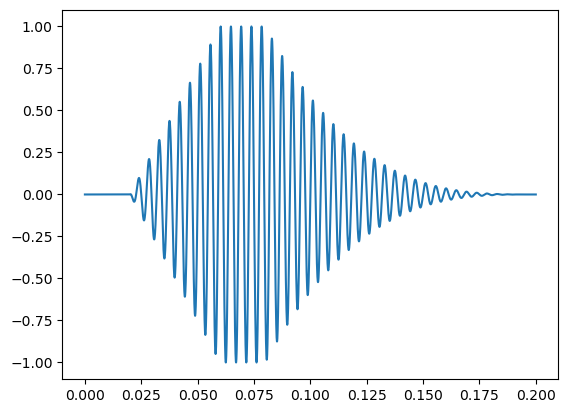

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def fade_in(t_0, dt, t_max, sample_rate=44100):
    low  = np.zeros(int(t_0 * sample_rate))
    fade = np.linspace(0,1, int(dt * sample_rate))
    high = np.ones(int((t_max-t_0-dt) * sample_rate))
    joined = np.concatenate((low, fade, high))
    fill = np.zeros(int(t_max*sample_rate - len(joined)))
    return np.concatenate((joined, fill))

def fade_out(t_0, dt, t_max, sample_rate=44100):
    high = np.ones(int(t_0 * sample_rate))
    fade = np.linspace(1,0, int(dt * sample_rate))
    low  = np.zeros(int((t_max-t_0-dt) * sample_rate))
    joined = np.concatenate((high, fade, low))
    fill = np.zeros(int(t_max*sample_rate - len(joined)))
    return np.concatenate((joined, fill))

freq = 220
duration = 0.2 # a short envelope so we can see the underlying sine
t = np.linspace(0, duration, int(duration*44100))
y  = np.sin(t * freq * (np.pi * 2))

amplitude = fade_in(0.1*duration,0.2*duration,duration) # linear fade in / attack
amplitude = amplitude * fade_out(0.4*duration,0.6*duration,duration) ** 3 # cubic fade out / release
y = y * amplitude
plt.plot(t,y)

In [5]:
freq = 220
duration = 2 # a longer envelope so that we can hear it
t = np.linspace(0, duration, int(duration*44100))
y  = np.sin(t * freq * (np.pi * 2))

amplitude = fade_in(0.1*duration, 0.2*duration, duration) # linear fade in / attack
amplitude = amplitude * fade_out(0.4*duration, 0.6*duration, duration) ** 3 # cubic fade out / release
y = y * amplitude

buffer = wavestacker.MonoAudioBuffer()
buffer.add_audio_data(y)
buffer.play()

## Overlay multiple signals

To mix multiple signals together we just add them up. The buffer expects a signal range from 0 to 1, so we have to normalise the summed up audio.

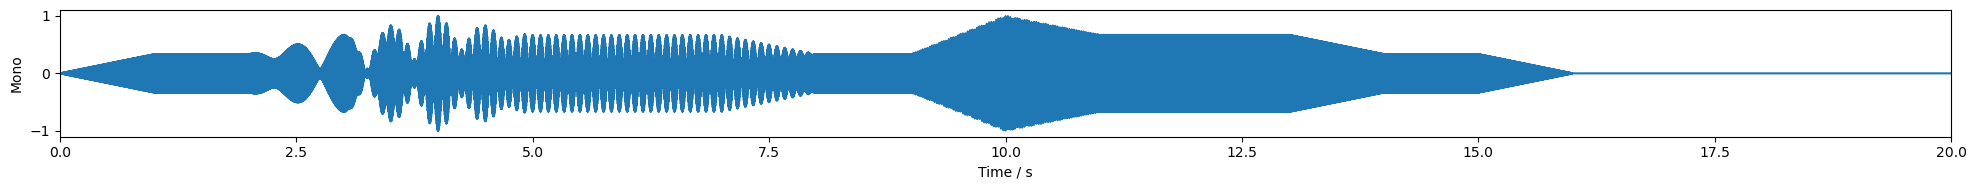

In [6]:
import wavestacker

def normalize_signal(y):
    max_val = np.max(np.abs(y))
    if max_val == 0: return y  # avoids division by zero
    return y / max_val

length = 20
t = np.linspace(0, length, length*44100)
track = np.zeros(length*44100)

frequencies = [220, 222, 210, 250, 250]
offsets =     [  0,   2,   3,   9,   9]
durations =   [  4,   5,   7,   6,   4]

for frequency, offset, duration in zip(frequencies, offsets, durations):
    y  = np.sin(t * frequency * (np.pi * 2))
    amplitude = fade_in(offset, 1, length) * fade_out(offset+duration, 1, length) 
    track += y * amplitude

y = normalize_signal(track)

buffer = wavestacker.MonoAudioBuffer()
buffer.add_audio_data(y)
buffer.plot()
buffer.play()

## Using a Mixer object

Using the modules Mixer object reduces some of the overhead. Instead of including the position of each sine pulse in its amplitude envelope, we pass it to the Mixer with a offset value of x seconds (i.e. it will start after x seconds). This makes the envelope creation more straight forward as we dont have to consider the lenght of the final track. The Mixer also takes care of normalising the signal and finding the right length of the mixed track.

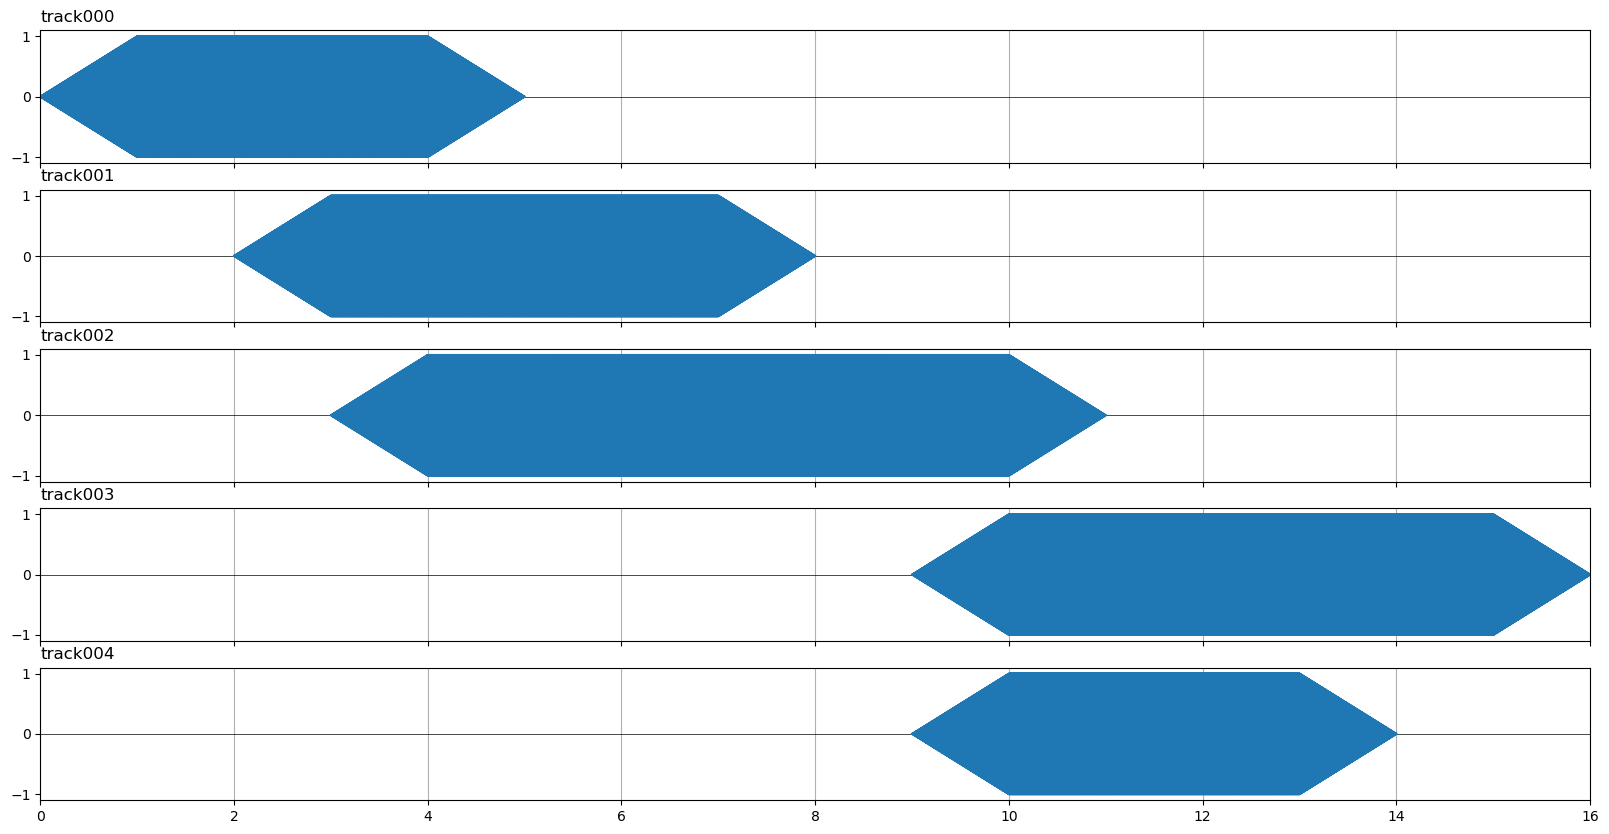

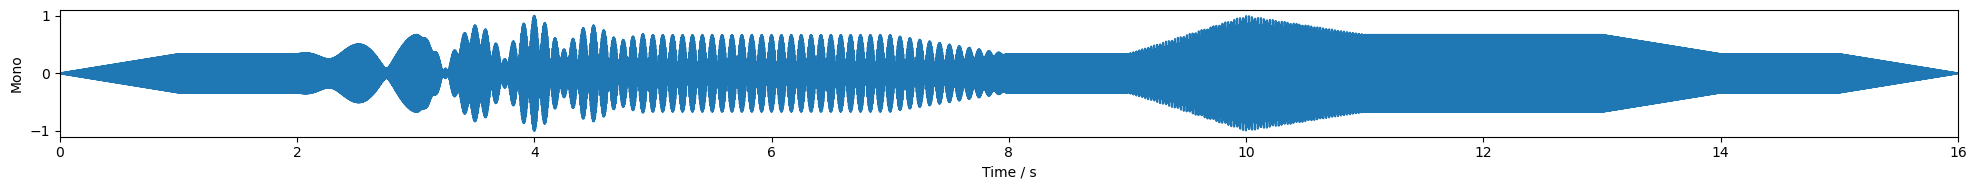

In [7]:
import wavestacker
import numpy as np

def peak_frequency(signal, sample_rate=44100):
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), 1 / sample_rate)
    peak_index = np.argmax(np.abs(fft_result))
    return abs(freqs[peak_index])

sample_rate = 44100
mixer = wavestacker.MonoMixer(sample_rate=sample_rate)

for frequency, offset, duration in zip(frequencies, offsets, durations):
    t = np.linspace(0, (duration + 1) , (duration + 1) * sample_rate)
    y = np.sin(t * frequency * (np.pi * 2))
    amplitude = np.concatenate((np.linspace(0,1,sample_rate), 
                                np.ones(sample_rate * (duration-1)), 
                                np.linspace(1,0,sample_rate)))
    mixer.add(y, amplitude, offset)


mixer.plot()
buffer = wavestacker.MonoAudioBuffer(sample_rate=sample_rate)
buffer.add_audio_data(mixer.get_mix())
buffer.plot()
buffer.play()